/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Accuracy: 0.74
Testing Accuracy: 0.70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.66      0.65        73
           1       0.82      0.70      0.76        64
           2       0.58      0.66      0.62        67
           3       0.81      0.79      0.80        66

    accuracy                           0.70       270
   macro avg       0.71      0.70      0.71       270
weighted avg       0.71      0.70      0.70       270

False Negative Rate for Class 0: 0.34
False Negative Rate for Class 1: 0.30
False Negative Rate for Class 2: 0.34
False Negative Rate for Class 3: 0.21


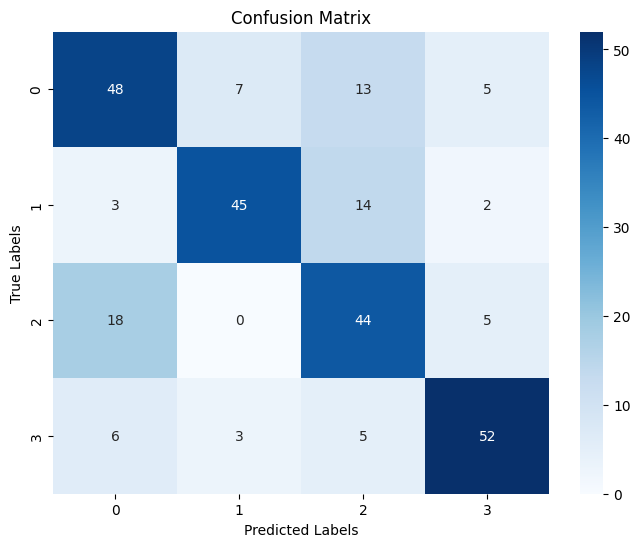

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


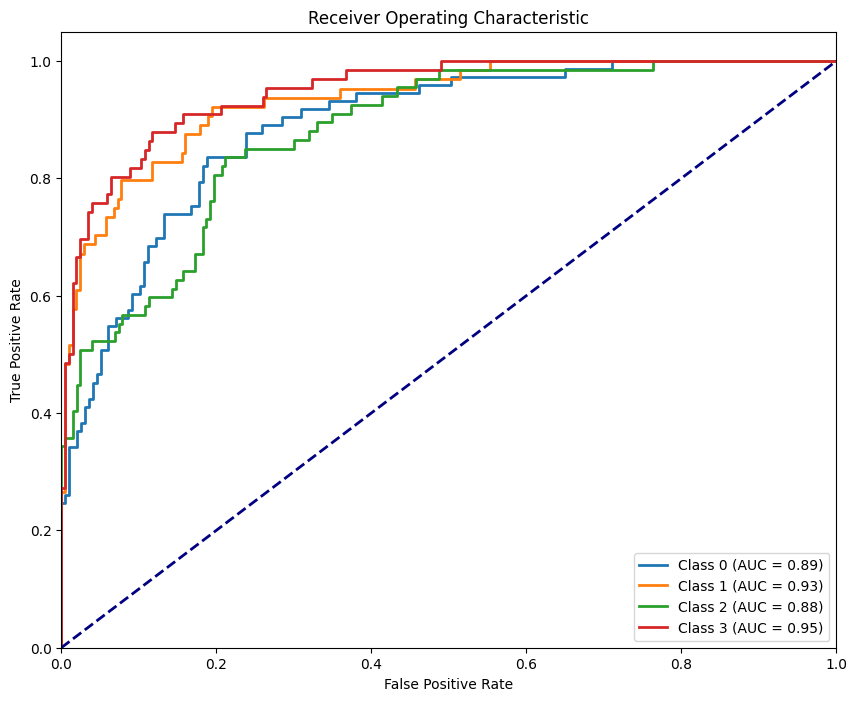

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the training dataset
data = pd.read_excel('/content/7features_f_4del.xlsx')
data = data.drop(columns=['Creatinine','Alkaline phosphatase','INR','Platelets'])
data.fillna(data.mean(numeric_only=True), inplace=True)

# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_7features_f_4del.xlsx')
test_data_from_file = test_data_from_file.drop(columns=['Creatinine','Alkaline phosphatase','INR','Platelets'])
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)

# Split features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)


# Define the MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation='softmax')  # Multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.0001)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[lr_reduction], verbose=0)

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_combined, y_test_combined, verbose=0)

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")

# Predict and evaluate performance
y_test_pred_combined = np.argmax(model.predict(X_test_combined), axis=1)

# Generate classification report
classes = np.unique(y_test_combined)
report = classification_report(y_test_combined, y_test_pred_combined, target_names=classes.astype(str))
print("\nClassification Report:\n", report)


# Confusion Matrix
cm_combined = confusion_matrix(y_test_combined, y_test_pred_combined)
# False Negative Rate (FNR) for each class
fn_rate_per_class = []
for i in range(len(cm_combined)):
    FN = sum(cm_combined[i, :]) - cm_combined[i, i]  # False Negatives
    TP = cm_combined[i, i]  # True Positives
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
    fn_rate_per_class.append(FNR)

# Display FNR for each class
for i, fnr in enumerate(fn_rate_per_class):
    print(f"False Negative Rate for Class {classes[i]}: {fnr:.2f}")


# Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

cm_combined = confusion_matrix(y_test_combined, y_test_pred_combined)
plot_confusion_matrix(cm_combined, classes)

# ROC Curve
plt.figure(figsize=(10, 8))
y_test_prob_combined = model.predict(X_test_combined)
for i, cls in enumerate(range(len(classes))):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




In [2]:
pip install scikeras


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


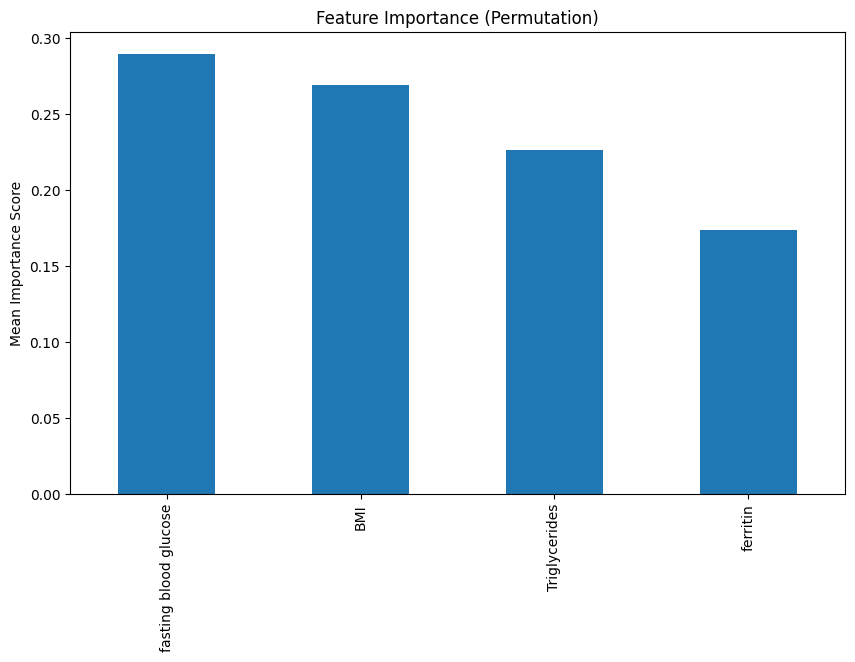

In [3]:
from scikeras.wrappers import KerasClassifier
from sklearn.inspection import permutation_importance

# Wrap the Keras model
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(len(np.unique(y)), activation='softmax')  # Multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

wrapped_model = KerasClassifier(model=create_model, epochs=50, batch_size=32, verbose=0)
wrapped_model.fit(X_train, y_train)

# Compute permutation importance
result = permutation_importance(wrapped_model, X_test_combined, y_test_combined, n_repeats=10, random_state=42)

# Plot feature importance
feature_importance = pd.Series(result.importances_mean, index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance (Permutation)')
plt.ylabel('Mean Importance Score')
plt.show()
